## L4-C - Building your own Quantizer: Quantize any Open Source PyTorch Model
In this lesson, you will look at the results of open source models compressed using the custom quantizer you built.

#### Step 1. Import all the required libraries

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from helpers import W8A16LinearLayer, replace_linear_with_target_and_quantize
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

### Step 2. Test the implementation on various LLMs
#### 2.1 Load the Model - [Salesforce/codegen-350M-mono](https://huggingface.co/Salesforce/codegen-350M-mono)

In [9]:
# Download the model from huggingface
pipeline("text-generation", model="Salesforce/codegen-350M-mono")

In [10]:
# Load the tokenizer and model from the saved environment
model_id = "Salesforce/codegen-350M-mono"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_id, 
                                    torch_dtype=torch.bfloat16, 
                                             low_cpu_mem_usage=True)

tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)


#### Step 2.2 Test the model's capability

In [12]:
print(pipe("def hellow_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hellow_world():\n    print("Hello World")\n\nhellow_world()\n\n# print(dir'}]


In [13]:
print("model before quantization: \n", model)

model before quantization: 
 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_featu

#### 3. Replace the model with our custom linear quantizer

In [15]:
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, ["lm_head"])
print("model after quantization: \n", pipe.model)

model after quantization: 
 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)


#### 3.1 Try our quantized model

In [16]:
print(pipe("def hellow_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hellow_world():\n    print("Hello World")\n\nhellow_world()\n\n# print(dir'}]


## Try Quantizer on Different Modality (Object Detection Models)

### 3.2 - [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

In [17]:
# Download the model from huggingface
pipeline("object-detection", model="facebook/detr-resnet-50")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
config.json: 100%|██████████| 4.59k/4.59k [00:00<00:00, 839kB/s]
model.safetensors: 100%|██████████| 167M/167M [00:23<00:00, 7.16MB/s] 


ImportError: 
DetrConvEncoder requires the timm library but it was not found in your environment. You can install it with pip:
`pip install timm`. Please note that you may need to restart your runtime after installation.


In [32]:
# Load model directly from huggingface

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
obj_dectector_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

In [33]:
## See memory footprint
previous_memory_footprint = obj_dectector_model.get_memory_footprint()
print("Memory footprint in MBs before quantization: ", previous_memory_footprint,"MBs")

Memory footprint in MBs before quantization:  166524032 MBs


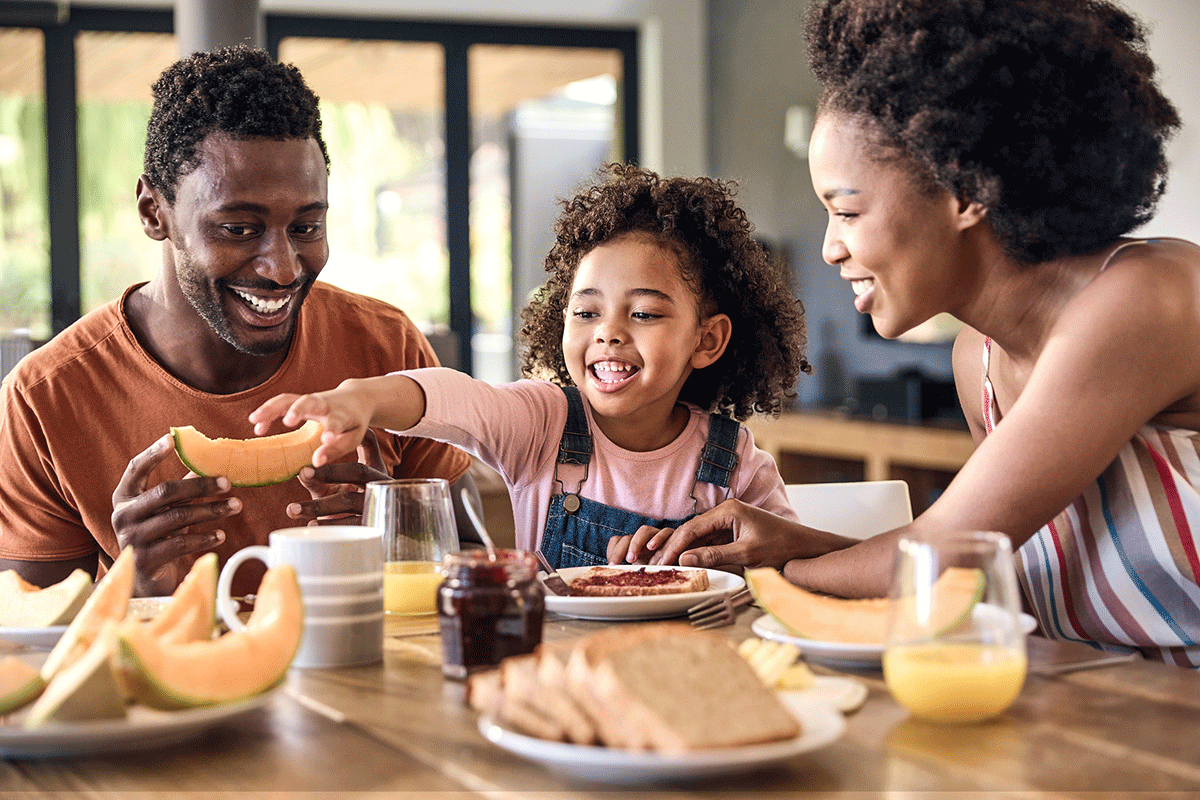

In [29]:
img_path = "../images/diner_with_friends.png"
image = Image.open(img_path).convert("RGB")
image

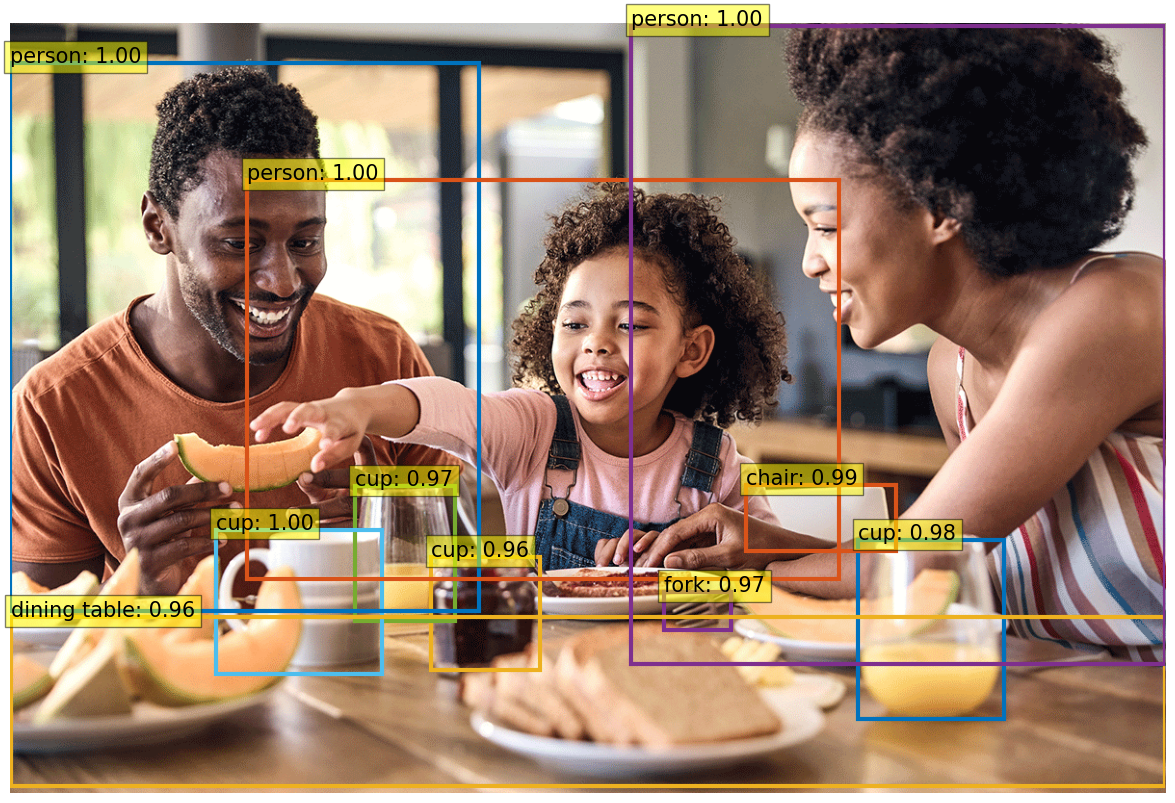

In [35]:
from helpers_extended import plot_results

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = obj_dectector_model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

plot_results(obj_dectector_model, image, results)

In [36]:
# see the model before quantization, we're not going to qunatize the convolutional layers
# we will only quantize the encoder and decoder layers, but not the llm_head

print("model before quantization: \n")
obj_dectector_model

model before quantization: 



DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

#### 3.2 Quantize the Object Detector
We're not going to quantize the convolutional layers and the last prediction layer.
- We're going to quantize all the attention layers (encoders and decoders).

In [38]:
replace_linear_with_target_and_quantize(obj_dectector_model, W8A16LinearLayer, ["0", "1", "2", "class_labels_classifier"])

In [39]:
# See the model after quantization
print("model after quantization: \n")
obj_dectector_model

model after quantization: 



DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

#### See how much Memory we have saved

In [41]:
## See memory footprint
quantized_memory_footprint = obj_dectector_model.get_memory_footprint()
print("Memory footprint in MBs After quantization: ", quantized_memory_footprint,"MBs")
print("Memory footprint reduction: ", previous_memory_footprint - quantized_memory_footprint, "MBs")

Memory footprint in MBs After quantization:  114803840 MBs
Memory footprint reduction:  51720192 MBs


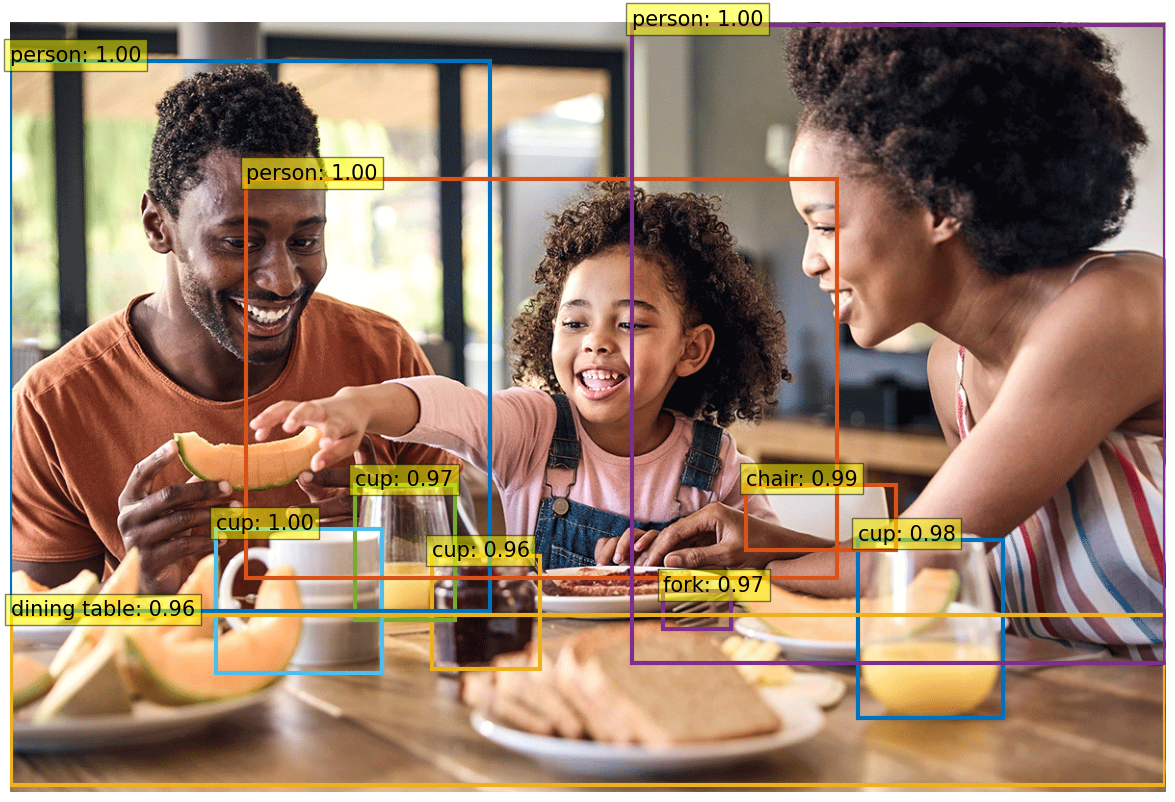

In [42]:
with torch.no_grad():
    outputs = obj_dectector_model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

plot_results(obj_dectector_model, image, results)